In [12]:
import os
import string
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_utils as prep


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as tftext

In [2]:
VOCAB_SIZE = 20_000
MAX_SEQUENCE_LENGTH = 50

In [3]:
dir_path = "conll2003_data"

train_data = prep.read_iob_file(os.path.join(dir_path, "train.txt"))
valid_data = prep.read_iob_file(os.path.join(dir_path, "valid.txt"))
test_data = prep.read_iob_file(os.path.join(dir_path, "test.txt"))

x_train, vocab = prep.preprocess_tokens(train_data["tokens"], VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_train, class_names = prep.preprocess_entity_tags(train_data["entity_tags"], MAX_SEQUENCE_LENGTH)

x_valid, _ = prep.preprocess_tokens(valid_data["tokens"], VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_valid, _ = prep.preprocess_entity_tags(valid_data["entity_tags"], MAX_SEQUENCE_LENGTH)

x_test, _ = prep.preprocess_tokens(test_data["tokens"], VOCAB_SIZE, MAX_SEQUENCE_LENGTH)
y_test, _ = prep.preprocess_entity_tags(test_data["entity_tags"], MAX_SEQUENCE_LENGTH)

In [4]:
print(f"Train examples:      {x_train.shape[0]}, vocabulary length: {len(vocab)}, classes: {len(class_names)}")
print(f"Validation examples: {x_valid.shape[0]}")
print(f"Test examples:       {x_test.shape[0]}")

Train examples:      14018, vocabulary length: 19998, classes: 9
Validation examples: 3242
Test examples:       3450


In [5]:
class SparseCategoricalCrossentropyIgnorePaddingLoss(keras.losses.Loss):
    def __init__(self, from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=from_logits,
            reduction=keras.losses.Reduction.NONE
        )
    
    def call(self, y_true, y_pred):
        loss = self.loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.dtypes.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)
        
        

In [6]:
inputs = layers.Input(shape=(None,))
x = layers.Embedding(VOCAB_SIZE, 64, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
outputs = layers.TimeDistributed(layers.Dense(10))(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          1280000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        197632    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                           

In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=SparseCategoricalCrossentropyIgnorePaddingLoss(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_valid, y_valid)
)

Epoch 1/10
220/220 [==============================] - 1274s 6s/step - loss: 0.2063 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.2960 - val_sparse_categorical_accuracy: 0.7813
Epoch 2/10
220/220 [==============================] - 1314s 6s/step - loss: 0.0987 - sparse_categorical_accuracy: 0.8725 - val_loss: 0.4735 - val_sparse_categorical_accuracy: 0.7208
Epoch 3/10
220/220 [==============================] - 1461s 7s/step - loss: 0.0559 - sparse_categorical_accuracy: 0.9277 - val_loss: 0.5465 - val_sparse_categorical_accuracy: 0.7189
Epoch 4/10
220/220 [==============================] - 1479s 7s/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9517 - val_loss: 0.5676 - val_sparse_categorical_accuracy: 0.7053
Epoch 5/10
220/220 [==============================] - 1500s 7s/step - loss: 0.0278 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.5811 - val_sparse_categorical_accuracy: 0.7066
Epoch 6/10
220/220 [==============================] - 1480s 7s/step - loss: 0.0202 - spars

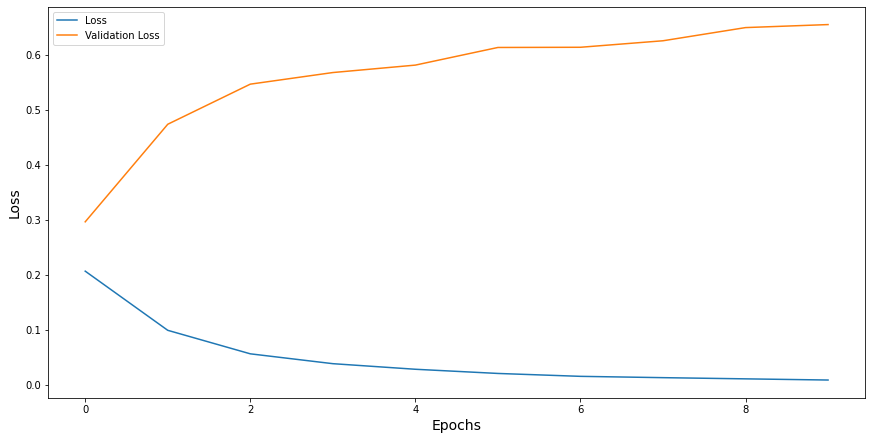

In [16]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(history.history["loss"], label="Loss")
ax.plot(history.history["val_loss"], label="Validation Loss")
ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.legend()
plt.show()

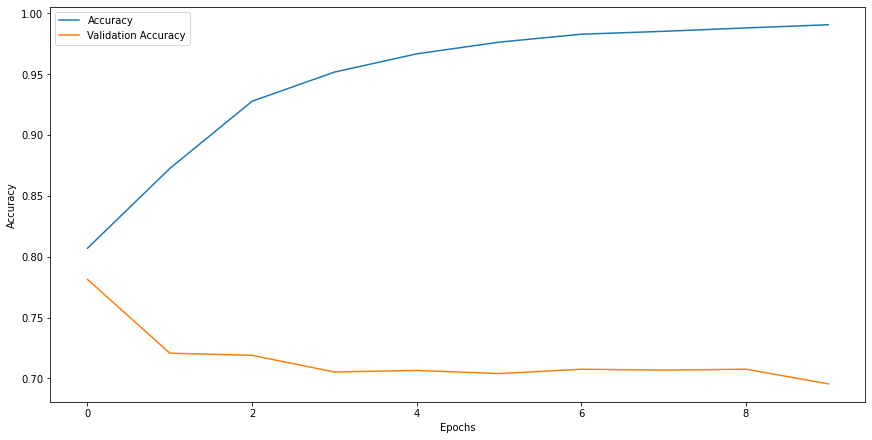

In [17]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
ax.plot(history.history["sparse_categorical_accuracy"], label="Accuracy")
ax.plot(history.history["val_sparse_categorical_accuracy"], label="Validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

In [18]:
results = model.evaluate(x_test, y_test)
print(results)

108/108 [==============================] - 65s 599ms/step - loss: 0.5592 - sparse_categorical_accuracy: 0.6909
[0.5592381954193115, 0.6908696889877319]


In [18]:
bert_model_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_preprocess_model = hub.KerasLayer(bert_preprocessor_url)

In [34]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [33]:
text_preprocessed = hub.KerasLayer(bert_model_url)

In [35]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_model_url}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611842  0.36673835  0.15233713  0.6550445
  0.9681154  -0.94862705  0.00216199 -0.9877732   0.06842697 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.3432126   0.33231524 ...  0.21300834  0.71020776
  -0.05771159]
 [-0.28742072  0.31980997 -0.23018596 ...  0.5845511  -0.21329741
   0.7269215 ]
 [-0.66157013  0.6887673  -0.8743302  ...  0.10877225 -0.26173237
   0.47855318]
 ...
 [-0.22561178 -0.2892561  -0.07064433 ...  0.4756602   0.83277094
   0.4002539 ]
 [-0.29824233 -0.27473113 -0.05450515 ...  0.48849773  1.0955355
   0.18163365]
 [-0.4437818   0.00930784  0.07223748 ...  0.17290097  1.183325
   0.07897963]]


In [24]:
bert_results.keys()

dict_keys(['pooled_output', 'encoder_outputs', 'sequence_output', 'default'])

In [25]:
text_input = layers.Input(shape=(), dtype=tf.string, name="text")
preprocessing_layer = hub.KerasLayer(bert_preprocess_url, name="preprocessing")
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_model_url, trainable=True, name="BERT_encoder")
outputs = encoder(encoder_inputs)
net = outputs["pooled_output"]
net = layers.Dropout(0.1)(net)
net = layers.Dense(1, activation=None, name="classifier")(net)

In [28]:
text_input = layers.Input(shape=(), dtype=tf.string, name="text")
preprocessing_layer = hub.KerasLayer(bert_preprocess_url, name="preprocessing")
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_model_url, trainable=True, name="BERT_encoder")
outputs = encoder(encoder_inputs)
net = outputs["sequence_output"]
# net = layers.Dropout(0.1)(net)
net = layers.TimeDistributed(layers.Dense(10, name="classifier"))(net)
model = keras.Model(inputs=text_input, outputs=net)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [30]:
train_data.keys()

dict_keys(['tokens', 'pos_tags', 'chunk_tags', 'entity_tags'])

In [ ]:
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].